In [267]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import datetime
import json

import matplotlib.pyplot as plt

In [268]:
def parse_if_number(s):
    try:
        return float(s)
    except:
        return True if s == "true" else False if s == "false" else s if s else None

In [269]:
def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

In [270]:
def parse_vectime_vecvalue(df):

    new_df = pd.DataFrame(columns=["Node", "Name", "Time", "Value"])

    names = []
    nodes = []

    count = 1

    print("Parsing vector file")

    vectimes = np.array([])
    vecvalues = np.array([])

    df_len = len(df.index)

    for index, row in df.iterrows():
        names.append([row[2] for _ in range(len(row.vectime))])
        nodes.append([row.node for _ in range(len(row.vectime))])
        vectimes = np.concatenate((vectimes, row.vectime))
        vecvalues = np.concatenate((vecvalues, row.vecvalue))

        print("Processed row: {} of {}".format(count, df_len))
        count += 1
        break

    new_df = new_df.append({"Node": nodes, "Name": names, "Time": vectimes, "Value": vecvalues}, ignore_index=True)

    return new_df

In [271]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [350]:
raw_results = "/home/brian/results-analysis/data/raw_data/winner-no-interference2.csv"
stats = "/home/brian/results-analysis/configs/mode4-stats.json"

In [351]:
raw_df = pd.read_csv(raw_results, converters={
        "attrvalue": parse_if_number,
        "binedges" : parse_ndarray,
        "binvalues": parse_ndarray,
        "vectime"  : parse_ndarray,
        "vecvalue" : parse_ndarray})

print("Loaded csv into DataFrame")

Loaded csv into DataFrame


In [352]:
reset_df = raw_df

In [353]:
# Run when we want to reset the DF As the current being loaded in is large
raw_df = reset_df

In [354]:
# It's likely this will change depending on the run/system
# Might be worth investigating some form of alternative
broken_module = raw_df['module'].str.split('.', 3, expand=True)

raw_df["network"] = broken_module[0]
raw_df["node"] = broken_module[1]
raw_df["interface"] = broken_module[2]
raw_df["layer"] = broken_module[3]

raw_df = raw_df.drop("module", axis=1)

In [355]:
# Remove junk from common node names
raw_df.node = raw_df.node.str.replace("node", "")
raw_df.node = raw_df.node.str.replace("[", "")
raw_df.node = raw_df.node.str.replace("]", "")
raw_df.node = raw_df.node.str.replace("car", "")

In [356]:
if stats:
    with open(stats) as json_file:
        data = json.load(json_file)
        raw_df = raw_df[raw_df.name.isin(data["filtered_vectors"]) | raw_df.name.isin(data["filtered_scalars"])]
        raw_df = raw_df.reset_index(drop=True)        

In [357]:
raw_df.name.unique()

array(['txRxDistance:mean', 'tbAndSCINotReceived:sum',
       'tbFailedButSCIReceived:sum', 'tbsFailedDueToNoSCI:sum',
       'tbsDecoded:sum', 'tbsReceived:sum', 'tbsSent:sum', 'scisSent:sum',
       'scisNotDecoded:sum', 'scisDecoded:sum', 'scisReceived:sum',
       'cbr:mean', 'scisSent:vector', 'tbsSent:vector',
       'txRxDistance:vector', 'scisReceived:vector', 'scisDecoded:vector',
       'scisNotDecoded:vector', 'tbsReceived:vector', 'tbsDecoded:vector',
       'tbsFailedDueToNoSCI:vector', 'tbFailedButSCIReceived:vector'],
      dtype=object)

In [358]:
# This will always remain the same for all runs.
broken_run = raw_df['run'].str.split('-', 4, expand=True)

raw_df["scenario"] = broken_run[0]
raw_df["run"] = broken_run[1]
raw_df["date"] = broken_run[2]
raw_df["time"] = broken_run[3]
raw_df["processId"] = broken_run[4]

In [359]:
runattr_df = raw_df[raw_df["type"] == "runattr"]
runattr_df = runattr_df.dropna(axis=1, how="all")
runattr_df = runattr_df.reset_index(drop=True)

In [360]:
itervar_df = raw_df[raw_df["type"] == "itervar"]
itervar_df = itervar_df.dropna(axis=1, how="all")
itervar_df = itervar_df.reset_index(drop=True)

In [361]:
param_df = raw_df[raw_df["type"] == "param"]
param_df = param_df.dropna(axis=1, how="all")
param_df = param_df.reset_index(drop=True)

In [362]:
attr_df = raw_df[raw_df["type"] == "attr"]
attr_df = attr_df.dropna(axis=1, how="all")
attr_df = attr_df.reset_index(drop=True)

In [363]:
scalar_df = raw_df[raw_df["type"] == "scalar"]
scalar_df = scalar_df.dropna(axis=1, how="all")
scalar_df = scalar_df.reset_index(drop=True)

In [364]:
vector_df = raw_df[raw_df["type"] == "vector"]
vector_df = vector_df.dropna(axis=1, how="all")
vector_df = vector_df.reset_index(drop=True)

### Different approach

In [365]:
rows_we_want = vector_df.drop(["run", "type", "network", "interface", "layer", "scenario", "date", "time", "processId"], axis=1)
rows_we_want = rows_we_want.reset_index(drop=True)

In [366]:
lst_col = "vectime"
test = pd.DataFrame({
    col:np.repeat(rows_we_want[col].values, rows_we_want[lst_col].str.len())
    for col in rows_we_want.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(rows_we_want[lst_col].values)})[rows_we_want.columns.tolist()]

In [367]:
vecvalue_split = test

In [368]:
lst_col = "vecvalue"
testB = pd.DataFrame({
    col:np.repeat(rows_we_want[col].values, rows_we_want[lst_col].str.len())
    for col in rows_we_want.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(rows_we_want[lst_col].values)})[rows_we_want.columns.tolist()]

In [369]:
testB["vectime"] = test["vectime"]

In [370]:
node_include_df = testB

In [371]:
node_include_df.shape

(24342909, 4)

In [372]:
node_include_df.head()

,name,vectime,vecvalue,node
0,scisSent:vector,201.102,1.0,34
1,scisSent:vector,201.202,1.0,34
2,scisSent:vector,201.302,1.0,34
3,scisSent:vector,201.402,1.0,34
4,scisSent:vector,201.502,1.0,34


In [373]:
node_filtered_df = node_include_df[node_include_df["name"] == "txRxDistance:vector"]

In [375]:
node_filtered_df.head()
node_filtered_df = node_filtered_df.iloc[::2, :]
node_filtered_df.shape

(2701641, 4)

In [374]:
node_filtered_df.head()
node_filtered_df = node_filtered_df.reset_index(drop=True)

In [376]:
received   = node_include_df[node_include_df["name"] == "tbsReceived:vector"]
failed_tb  = node_include_df[node_include_df["name"] == "tbFailedButSCIReceived:vector"]
failed_sci = node_include_df[node_include_df["name"] == "tbsFailedDueToNoSCI:vector"]

received = received.reset_index(drop=True)
failed_sci = failed_sci.reset_index(drop=True)
failed_tb = failed_tb.reset_index(drop=True)

In [377]:
merged_df = pd.DataFrame()
merged_df["time"] = received["vectime"]
merged_df["distance"] = node_filtered_df["vecvalue"]
merged_df["received"] = received["vecvalue"]
merged_df["failed_tb"] = failed_tb["vecvalue"]
merged_df["failed_sci"] = failed_sci["vecvalue"]

In [378]:
merged_df.head()

,time,distance,received,failed_tb,failed_sci
0,201.103,134.908073,1.0,0.0,0.0
1,201.106,NaN,1.0,0.0,0.0
2,201.107,90.627206,1.0,0.0,0.0
3,201.107,NaN,1.0,0.0,0.0
4,201.108,1911.592181,1.0,0.0,0.0


In [379]:
merged_df.describe()

,time,distance,received,failed_tb,failed_sci
count,2.701641e+06,1.350821e+06,2701641.0,2.701641e+06,2.701641e+06
mean,2.056030e+02,9.275300e+02,1.0,5.182036e-06,2.348943e-03
std,2.588515e+00,6.520801e+02,0.0,2.276403e-03,4.840895e-02
min,2.011030e+02,4.000101e+00,1.0,0.000000e+00,0.000000e+00
25%,2.032940e+02,3.724385e+02,1.0,0.000000e+00,0.000000e+00
50%,2.056620e+02,8.221052e+02,1.0,0.000000e+00,0.000000e+00
75%,2.078840e+02,1.377197e+03,1.0,0.000000e+00,0.000000e+00
max,2.100000e+02,2.775061e+03,1.0,1.000000e+00,1.000000e+00


In [380]:
merged_df["pdr"] = (merged_df["received"] - merged_df["failed_tb"] - merged_df["failed_sci"]/(merged_df["received"])) * 100

In [381]:
merged_df.head()

,time,distance,received,failed_tb,failed_sci,pdr
0,201.103,134.908073,1.0,0.0,0.0,100.0
1,201.106,NaN,1.0,0.0,0.0,100.0
2,201.107,90.627206,1.0,0.0,0.0,100.0
3,201.107,NaN,1.0,0.0,0.0,100.0
4,201.108,1911.592181,1.0,0.0,0.0,100.0


In [382]:
merged_df.describe()

,time,distance,received,failed_tb,failed_sci,pdr
count,2.701641e+06,1.350821e+06,2701641.0,2.701641e+06,2.701641e+06,2.701641e+06
mean,2.056030e+02,9.275300e+02,1.0,5.182036e-06,2.348943e-03,9.976459e+01
std,2.588515e+00,6.520801e+02,0.0,2.276403e-03,4.840895e-02,4.846219e+00
min,2.011030e+02,4.000101e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.032940e+02,3.724385e+02,1.0,0.000000e+00,0.000000e+00,1.000000e+02
50%,2.056620e+02,8.221052e+02,1.0,0.000000e+00,0.000000e+00,1.000000e+02
75%,2.078840e+02,1.377197e+03,1.0,0.000000e+00,0.000000e+00,1.000000e+02
max,2.100000e+02,2.775061e+03,1.0,1.000000e+00,1.000000e+00,1.000000e+02


In [383]:
bins = create_bins(lower_bound=0, width=10, quantity=49)

In [384]:
distances = []
pdrs_highway_fast = []
for interval in bins:
    lower_b = interval[0]
    upper_b = interval[1]
    pdr_temp_highway_fast = merged_df[(merged_df["distance"] >= lower_b) & (merged_df["distance"] < upper_b)]
    pdrs_highway_fast.append(pdr_temp_highway_fast["pdr"].mean())
    distances.append(upper_b)

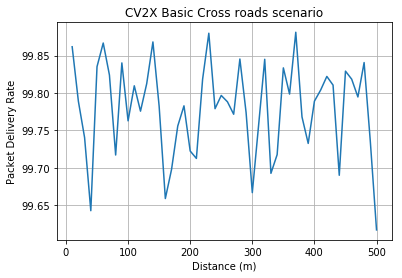

In [385]:
fig, ax = plt.subplots()
ax.plot(distances, pdrs_highway_fast)
ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate',
       title='CV2X Basic Cross roads scenario')
ax.grid()

fig.savefig("figures/highway_fast.png")
plt.show()

### Finished fixing vector DF

In [ ]:
vector_df = parse_vectime_vecvalue(vector_df)

In [ ]:
now = datetime.datetime.now()
if args.name != now:
    directory = "{}/{}-{}".format(args.tidied_results, now.strftime("%Y-%m-%d_%H:%M"), args.name)
else:
    directory = "{}/{}".format(args.tidied_results, now.strftime("%Y-%m-%d_%H:%M"))

os.mkdir(directory)

runattr_df.to_csv("{}/{}".format(directory, "runattr.csv"), index=False)
itervar_df.to_csv("{}/{}".format(directory, "itervar.csv"), index=False)
param_df.to_csv("{}/{}".format(directory, "params.csv"), index=False)
attr_df.to_csv("{}/{}".format(directory, "attr.csv"), index=False)
vector_df.to_csv("{}/{}".format(directory, "vector.csv"), index=False)
scalar_df.to_csv("{}/{}".format(directory, "scalar.csv"), index=False)